In [2]:
from google.colab import drive

# This will prompt you to authenticate and grant access to your Drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [4]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best Parameters for Highest Accuracy:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Highest Accuracy on Validation Set: 0.8125
Log Loss of Best Accuracy Model on Test Set: 0.4676


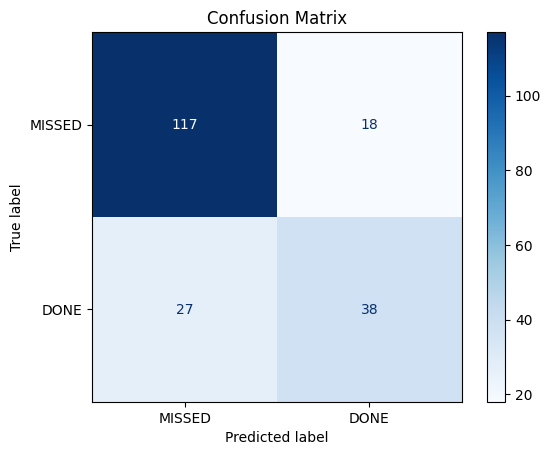

In [5]:
# Create new column for absolute difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop QuotedPrice and MidPrice columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Feature matrix and target vector
X = df.drop(columns=['Traded'])
y = df['Traded']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Grid search for highest accuracy
grid_search_acc = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy for grid search
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model for accuracy
grid_search_acc.fit(X_train, y_train)

# Best parameters for highest accuracy
best_params_accuracy = grid_search_acc.best_params_
highest_accuracy = grid_search_acc.best_score_

# Evaluate the best model on test data for log loss
best_xgb_acc = grid_search_acc.best_estimator_
y_pred_prob_acc = best_xgb_acc.predict_proba(X_test)
log_loss_acc_model = log_loss(y_test, y_pred_prob_acc)
y_pred = best_xgb_acc.predict(X_test)

# Output the results
print("\nBest Parameters for Highest Accuracy:")
print(best_params_accuracy)
print(f"Highest Accuracy on Validation Set: {highest_accuracy:.4f}")
print(f"Log Loss of Best Accuracy Model on Test Set: {log_loss_acc_model:.4f}")
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["MISSED", "DONE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}

In [6]:
# Preprocess OS data
def preprocess_os_data(df, training_columns):
    # Create new column for absolute difference
    df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

    # Drop irrelevant columns
    df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time'])

    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

    # Ensure the OS data has the same columns as training data
    for col in training_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns with default value 0

    # Ensure column order matches training data
    df = df[training_columns]

    return df

In [7]:
# Assuming OS data is loaded as `os_df`
os_df = pd.read_csv('/content/drive/MyDrive/FX/os.csv')  # Replace with the actual path to your OS data
os_df = os_df.dropna()

# Preprocess OS data
training_columns = X_train.columns  # Columns used during training
os_X = preprocess_os_data(os_df, training_columns)

# Reinitialize XGBoost with best_params_accuracy
xgb_best = XGBClassifier(**best_params_accuracy, use_label_encoder=False, eval_metric='logloss')


# # Fit the model on the entire training data
xgb_best.fit(X, y)

# Predict probabilities and class labels on OS data
os_pred_prob = xgb_best.predict_proba(os_X)  # Predict probabilities
os_pred_class = xgb_best.predict(os_X)       # Predict class labels

# Add predictions to OS data
os_df['Predicted_Probability_DONE'] = os_pred_prob[:, 1]  # Probability of TRADED = DONE
os_df['Predicted_Trade_Class'] = os_pred_class  # Predicted class (0 = MISSED, 1 = DONE)

# Output the results
print(os_df[['Predicted_Probability_DONE', 'Predicted_Trade_Class']])

    Predicted_Probability_DONE  Predicted_Trade_Class
0                     0.049190                      0
1                     0.180139                      0
2                     0.050213                      0
3                     0.311769                      0
4                     0.706879                      1
..                         ...                    ...
95                    0.593501                      1
96                    0.078613                      0
97                    0.082759                      0
98                    0.123903                      0
99                    0.134439                      0

[100 rows x 2 columns]


In [8]:
value_counts = os_df['Predicted_Trade_Class'].value_counts()
value_counts

,count
Predicted_Trade_Class,
0,87
1,13


In [9]:
# Assuming os_df is your DataFrame containing the predictions
os_df['Predicted_Trade_Class'] = os_df['Predicted_Trade_Class'].map({0: 'MISSED', 1: 'DONE'})

In [10]:
os_df

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,AbsPriceDiff,Predicted_Probability_DONE,Predicted_Trade_Class
0,4418,US Treasury 30Y,BID,500000.0,SleepyManager,97.219,97.053,6.0,0.166,0.049190,MISSED
1,4422,US Treasury 3Y,ASK,500000.0,HF-Fortress,103.970,104.046,4.0,0.076,0.180139,MISSED
2,4430,US Treasury 10Y,ASK,500000.0,CountrysideBroker,98.477,98.609,5.0,0.132,0.050213,MISSED
3,4437,US Treasury 2Y,ASK,5000000.0,RelativeValueStrategies,99.928,100.035,4.0,0.107,0.311769,MISSED
4,4444,US Treasury 3Y,ASK,2500000.0,HF-Fortress,103.040,103.136,2.0,0.096,0.706879,DONE
...,...,...,...,...,...,...,...,...,...,...,...
95,4855,US Treasury 5Y,BID,5000000.0,HF-Fortress,98.829,98.713,1.0,0.116,0.593501,DONE
96,4861,US Treasury 3Y,BID,500000.0,SniperFund,101.959,101.883,5.0,0.076,0.078613,MISSED
97,4867,US Treasury 5Y,BID,2500000.0,SniperFund,98.929,98.827,5.0,0.102,0.082759,MISSED
98,4868,US Treasury 3Y,ASK,2500000.0,SleepyManager,101.209,101.308,7.0,0.099,0.123903,MISSED


In [11]:
os_df.to_csv('/content/drive/MyDrive/FX/os_completed.csv')

In [12]:
training_columns = ['Notional', 'Competitors', 'AbsPriceDiff', 'Side_BID',
       'Counterparty_HF-Fortress', 'Counterparty_RelativeValueStrategies',
       'Counterparty_SleepyManager', 'Counterparty_SniperFund',
       'Counterparty_TankerAssetManagement', 'Bond_US Treasury 2Y',
       'Bond_US Treasury 30Y', 'Bond_US Treasury 3Y', 'Bond_US Treasury 5Y']
best_params_accuracy = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}

In [13]:
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

# Create new column for absolute difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop QuotedPrice and MidPrice columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Feature matrix and target vector
X = df.drop(columns=['Traded'])
y = df['Traded']

xgb_model = XGBClassifier(**best_params_accuracy, use_label_encoder=False, eval_metric='logloss')

# # Fit the model on the entire training data
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
def traded_prob_model(bond, side, notional, counterparty, mid_price, competitors, quoted_price):
  global training_columns, xgb_model

  input_data = pd.DataFrame({
        'Bond': [bond],
        'Side': [side],
        'Notional': [notional],
        'Counterparty': [counterparty],
        'MidPrice': [mid_price],
        'Competitors': [competitors],
        'QuotedPrice': [quoted_price]
    })

  # Calculate the absolute price difference
  input_data['AbsPriceDiff'] = abs(input_data['QuotedPrice'] - input_data['MidPrice'])

  # Drop irrelevant columns
  input_data = input_data.drop(columns=['QuotedPrice', 'MidPrice'])

  # Encode categorical variables
  input_data = pd.get_dummies(input_data, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

  # Add missing columns with default value 0 to match training data
  for col in training_columns:
      if col not in input_data.columns:
          input_data[col] = 0

  # Ensure column order matches training data
  input_data = input_data[training_columns]

  # Predict using the trained model
  pred_prob = xgb_model.predict_proba(input_data)[:, 1]  # Probability of DONE
  pred_class = xgb_model.predict(input_data)[0]          # Predicted class

  return pred_prob, pred_class

In [15]:
# Example usage
# Ensure that the global model xgb_model is trained
# Uncomment the following lines to use after training
predicted_prob, predicted_class = traded_prob_model(
    bond="US Treasury 30Y",
    side="BID",
    notional=1000000,
    counterparty="SleepyManager",
    mid_price=97.219,
    competitors=6,
    quoted_price=97.22
)

print("Predicted Probability of DONE:", predicted_prob)
print("Predicted Trade Class:", predicted_class)

Predicted Probability of DONE: [0.6402246]
Predicted Trade Class: 1


In [16]:
predicted_prob, predicted_class = traded_prob_model(
    bond="US Treasury 30Y",
    side="BID",
    notional=100000,
    counterparty="RelativeValueStrategies",
    mid_price=96.490,
    competitors=4,
    quoted_price=96.46
)

print("Predicted Probability of DONE:", predicted_prob)
print("Predicted Trade Class:", predicted_class)

Predicted Probability of DONE: [0.58272207]
Predicted Trade Class: 1


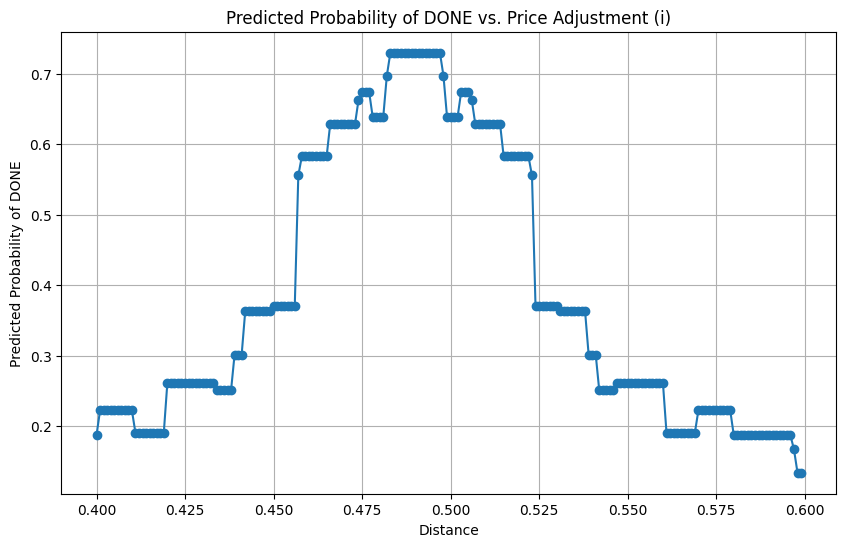

In [17]:
probabilities = []
for i in range(400, 600):
  quoted_price = 96 + i / 1000
  predicted_prob, predicted_class = traded_prob_model(
    bond="US Treasury 30Y",
    side="BID",
    notional=100000,
    counterparty="RelativeValueStrategies",
    mid_price=96.490,
    competitors=4,
    quoted_price=quoted_price
  )
  probabilities.append(predicted_prob)

i_values = range(400, 600)
quoted_price_adjustments = [i / 1000 for i in i_values]
# Plotting probabilities vs. i
plt.figure(figsize=(10, 6))
plt.plot(quoted_price_adjustments, probabilities, marker='o')
plt.title("Predicted Probability of DONE vs. Price Adjustment (i)")
plt.xlabel("Distance")
plt.ylabel("Predicted Probability of DONE")
plt.grid(True)
plt.show()

In [ ]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")
# df[(df['Bond']=='US Treasury 30Y') & (df['Side'] == 'BID') & (df['Counterparty']=="RelativeValueStrategies") ]
df_bid = df[(df['Traded'] == 'MISSED') & (df['Side'] == 'BID')]
df_bid['Distance_from_next'] = df_bid['QuotedPrice'] - df_bid['nextMidPrice']
df_bid['Distance_from_mid'] = df_bid['QuotedPrice'] - df_bid['MidPrice']

In [ ]:
df_bid[df_bid['Distance_from_mid']>0]

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,Traded,nextMidPrice,Distance_from_next,Distance_from_mid
225,1013,US Treasury 30Y,BID,500000,RelativeValueStrategies,99.300,99.305,1,MISSED,99.913,-0.608,0.005
244,1079,US Treasury 3Y,BID,100000,TankerAssetManagement,103.647,103.655,4,MISSED,103.567,0.088,0.008
447,1910,US Treasury 30Y,BID,5000000,HF-Fortress,91.861,91.880,5,MISSED,91.617,0.263,0.019
734,3187,US Treasury 5Y,BID,100000,HF-Fortress,96.893,96.902,7,MISSED,96.990,-0.088,0.009
761,3287,US Treasury 10Y,BID,100000,TankerAssetManagement,95.671,95.692,7,MISSED,95.649,0.043,0.021


In [ ]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")
# df[(df['Bond']=='US Treasury 30Y') & (df['Side'] == 'BID') & (df['Counterparty']=="RelativeValueStrategies") ]
df_ask = df[(df['Traded'] == 'MISSED') & (df['Side'] == 'ASK')]
df_ask['Distance_from_next'] = df_ask['nextMidPrice'] - df_ask['QuotedPrice']
df_ask['Distance_from_mid'] = df_ask['MidPrice'] - df_ask['QuotedPrice']

In [ ]:
df_ask[df_ask['Distance_from_mid']>0]

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,Traded,nextMidPrice,Distance_from_next,Distance_from_mid
58,263,US Treasury 10Y,ASK,250000,RelativeValueStrategies,93.383,93.298,6,MISSED,93.670,0.372,0.085
265,1138,US Treasury 3Y,ASK,250000,SniperFund,101.760,101.723,5,MISSED,101.625,-0.098,0.037
348,1484,US Treasury 10Y,ASK,250000,SleepyManager,97.613,97.544,7,MISSED,97.787,0.243,0.069
351,1495,US Treasury 5Y,ASK,250000,SleepyManager,97.985,97.932,3,MISSED,97.890,-0.042,0.053
373,1628,US Treasury 5Y,ASK,100000,TankerAssetManagement,99.281,99.261,7,MISSED,99.014,-0.247,0.020
457,1945,US Treasury 30Y,ASK,250000,HF-Fortress,86.464,86.407,6,MISSED,86.357,-0.050,0.057
572,2439,US Treasury 5Y,ASK,500000,SleepyManager,98.777,98.773,5,MISSED,98.913,0.140,0.004
587,2511,US Treasury 30Y,ASK,1000000,SleepyManager,92.584,92.575,3,MISSED,92.443,-0.132,0.009
623,2678,US Treasury 10Y,ASK,500000,TankerAssetManagement,96.426,96.415,6,MISSED,96.678,0.263,0.011
705,3050,US Treasury 2Y,ASK,100000,CountrysideBroker,101.464,101.433,6,MISSED,101.480,0.047,0.031


In [18]:
com = pd.read_csv('/content/drive/MyDrive/FX/competition.csv')
com

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,Traded,nextMidPrice
0,4881,US Treasury 30Y,BID,2500000,SniperFund,94.198,94.014,1,NaN,NaN
1,4885,US Treasury 2Y,BID,10000000,CountrysideBroker,101.921,101.745,7,NaN,NaN
2,4885,US Treasury 2Y,BID,500000,SleepyManager,99.615,99.548,7,NaN,NaN
3,4894,US Treasury 3Y,ASK,2500000,RelativeValueStrategies,100.768,100.869,4,NaN,NaN
4,4903,US Treasury 5Y,ASK,5000000,SniperFund,99.960,100.077,4,NaN,NaN
5,4911,US Treasury 5Y,ASK,250000,SleepyManager,97.621,97.699,5,NaN,NaN
6,4913,US Treasury 30Y,BID,250000,RelativeValueStrategies,93.568,93.407,1,NaN,NaN
7,4920,US Treasury 30Y,BID,100000,RelativeValueStrategies,96.490,96.334,4,NaN,NaN
8,4925,US Treasury 10Y,BID,100000,HF-Fortress,94.950,94.839,7,NaN,NaN
9,4934,US Treasury 5Y,ASK,2500000,TankerAssetManagement,97.995,98.096,2,NaN,NaN


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (replace 'com' with your actual DataFrame)
com = pd.read_csv('/content/drive/MyDrive/FX/competition.csv')  # Adjust the path as needed

# Prepare to store results
all_probabilities = {}

# Iterate over each row in the DataFrame
for index, row in com.iterrows():
    probabilities = []
    mid_price = row['MidPrice']
    competitors = row['Competitors']
    bond = row['Bond']
    side = row['Side']
    notional = row['Notional']
    counterparty = row['Counterparty']

    # Calculate probabilities for a range of quoted prices
    for i in range(0, 200):
        quoted_price = mid_price + i / 1000  # Adjust quoted price
        predicted_prob, _ = traded_prob_model(
            bond=bond,
            side=side,
            notional=notional,
            counterparty=counterparty,
            mid_price=mid_price,
            competitors=competitors,
            quoted_price=quoted_price
        )
        probabilities.append(predicted_prob)

    # Store results for the current row
    all_probabilities[index] = {
        'quoted_price_adjustments': [i / 1000 for i in range(0, 200)],
        'probabilities': probabilities
    }



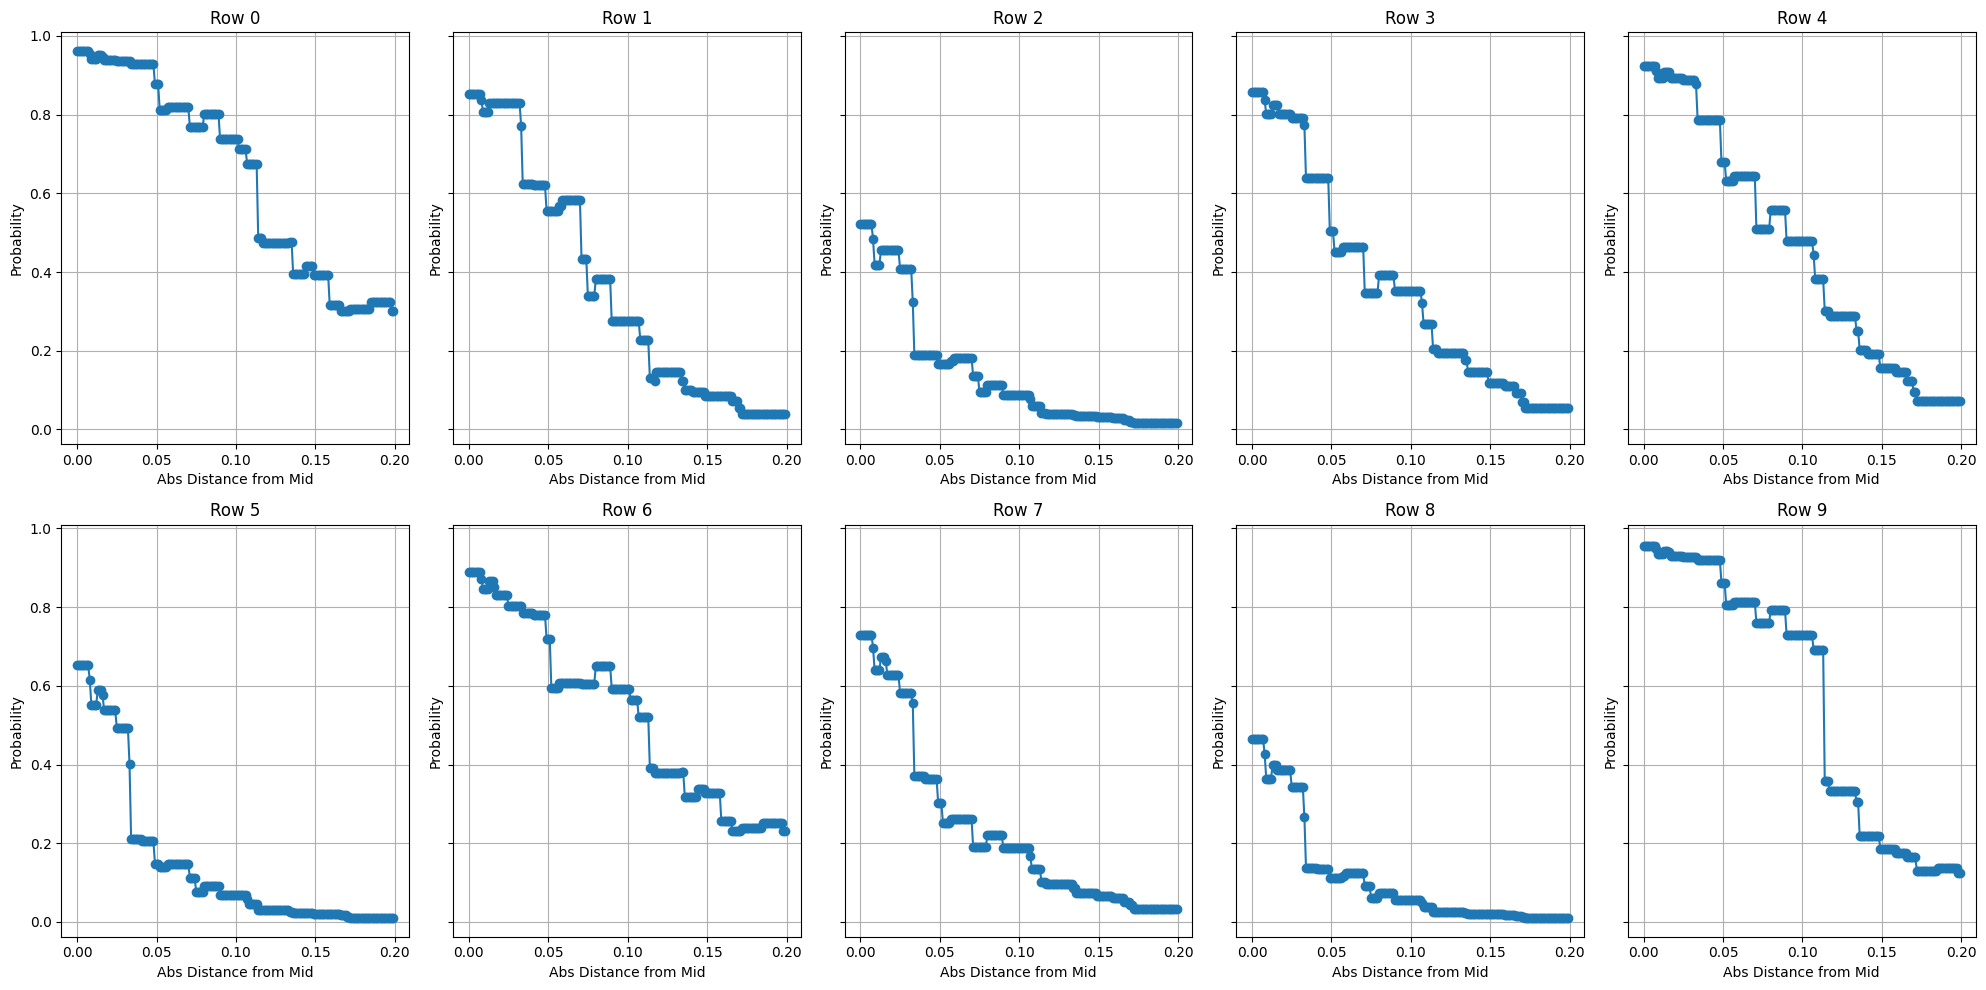

In [20]:
# Plotting the probabilities for the first 10 rows in a 2x5 grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for idx in range(10):
    if idx >= len(all_probabilities):  # Ensure we don't exceed the number of rows
        break

    result = all_probabilities[idx]
    ax = axes[idx]
    ax.plot(result['quoted_price_adjustments'], result['probabilities'], marker='o')
    ax.set_title(f"Row {idx}")
    ax.set_xlabel("Abs Distance from Mid")
    ax.set_ylabel("Probability")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()